# Packages 

In [1]:
from astropy.io import fits 
import matplotlib.pyplot as plt
import glob
import numpy as np

from minisom import MiniSom
from matplotlib.colors import ListedColormap
from matplotlib import colormaps

# Loading of SOM

In [2]:
# to convert the string from dictionary to dictionary
import ast 

# Load SOM parameters
with open('PARAMS_SOM_31points_Imax.txt', 'r') as f:
    params_str = f.read().strip()
    params = ast.literal_eval(params_str)  # Convert string to dictionary
    
    # Extract values from dictionary
    x, y, input_len = params['shape']
    sigma = params['sigma']
    learning_rate = params['learning_rate']

# Create SOM instance with parameters
som = MiniSom(x, y, input_len, sigma=sigma, learning_rate=learning_rate)

# load the weights
som._weights = np.load('Weights_SOM_31points_Imax.npy')

print(f"Shape: {x}x{y}, Dimensão de entrada: {input_len}")
print(f"Sigma: {sigma}, Taxa de aprendizado: {learning_rate}")

tamanho_mapa = (x,y)

Shape: 5x5, Dimensão de entrada: 124
Sigma: 2, Taxa de aprendizado: 1.5


# Open the test data

- **All events**
    - https://drive.google.com/drive/folders/1YxhCUdBSnPx4sSMn7hs2LoV-k0eC-x3y?usp=drive_link

In [3]:
AR = ['combined_10930_20061212_035005.fits',
      'combined_11692_20130314_210005.fits',
      'combined_11967_20140204_190005.fits',
      'combined_12209_20141123_062123.fits',
      'combined_12297_20150310_074505.fits',
      'combined_12297_20150310_093005.fits',
      'combined_12297_20150310_110406.fits',
      'combined_12297_20150310_165005.fits',
      'combined_12497_20160212_231005.fits',
      'combined_12567_20160722_233504.fits',
      'combined_12672_20170823_224005.fits',
      'combined_12727_20181117_130006.fits',
      'combined_12736_20190322_010205.fits']

### Use the AR index to select the event from the list above.
- Remember that python starts counting at zero

In [4]:
caminho = "C:\\Users\\mathe\\Doutorado\\Projeto_ML\\EVENTOS_ESPECTRO\\"+ AR[0]

# Data processing

In [5]:
hdul_teste = fits.open(caminho) 
data_teste = hdul_teste[0].data

stokes = np.copy(data_teste)
stokes = stokes.astype("float64")  

I_qs = np.max(stokes)  
stokes /= I_qs

In [6]:
ind_min = 30
        
I_ = stokes[:,:,0, ind_min-15:ind_min+16]
Q_ = stokes[:,:,1, ind_min-15:ind_min+16]
U_ = stokes[:,:,2, ind_min-15:ind_min+16]
V_ = stokes[:,:,3, ind_min-15:ind_min+16]

IQUV_concat = np.concatenate([I_, Q_, U_, V_], axis=-1)

data_reshaped = IQUV_concat.reshape(-1, 124)  # This is the input vector into the network

In [7]:
data_reshaped.shape

(512000, 124)

### Load the ColorMap

In [8]:
# Name of the file where the colors were saved
nome_arquivo_cores = 'cores_dos_clusters.npy'

# Load RGB colors 
loaded_cores_rgb = np.load(nome_arquivo_cores)

# Create the ListedColormap
custom_fixed_cmap = ListedColormap(loaded_cores_rgb)

# Apply SOM

In [9]:
# Get (x, y) coordinates of the winning neuron for each pixel
mapa_vencedores = np.array([som.winner(x) for x in data_reshaped])
mapa_vencedores = mapa_vencedores.reshape(IQUV_concat.shape[0], IQUV_concat.shape[1], 2)  

## Segmented figure

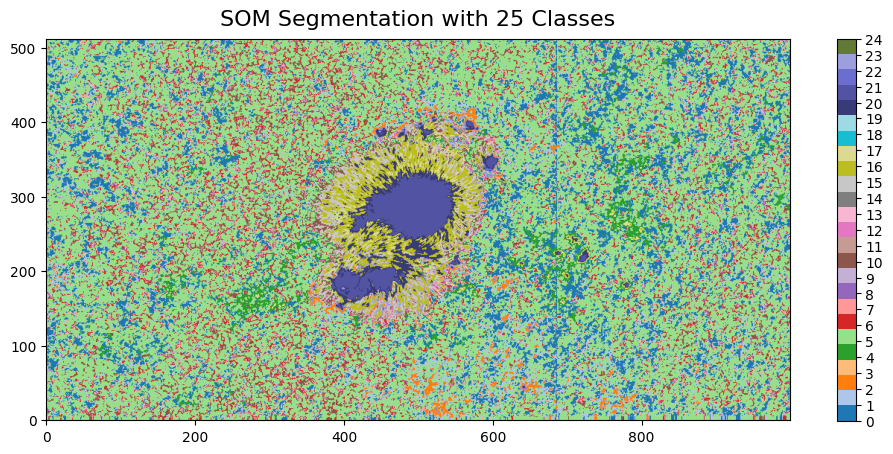

In [10]:
# Generate random colors for each neuron
num_classes = 25
np.random.seed(24)

cores_neurônios = np.arange(num_classes).reshape(tamanho_mapa)
cores_plot = custom_fixed_cmap(cores_neurônios / (num_classes - 1))[..., :3]

# Process winner map 
x_coords = mapa_vencedores[..., 0].astype(int)
y_coords = mapa_vencedores[..., 1].astype(int)

imagem_segmentada = cores_plot[x_coords, y_coords]

# Plot
plt.figure(figsize=(12, 8))
img = plt.imshow(imagem_segmentada, cmap = custom_fixed_cmap, origin='lower', vmin=0, vmax = num_classes-1) #custom_fixed_cmap 

cbar = plt.colorbar(img, shrink=0.62, cmap = cores_plot)
cbar.set_ticks(np.arange(num_classes))
cbar.set_ticklabels(np.arange(num_classes))

plt.title('SOM Segmentation with 25 Classes', fontsize= 16, pad= 10)

#plt.savefig('SOM Segmentation with 25 Classes.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

## Counting elements by class (Histogram)

In [11]:
# Turns the small into a list of unique 3D vectors}
vetores_pequenos = np.unique(cores_plot.reshape(-1, 3), axis=0)

# Create a mask to find all points in the large vector that are in small vectors
# Initialize a dictionary to store the positions
posicoes = {}

for vetor in vetores_pequenos:
    # Create mask where the pixels of arr_grande are equal to the vector
    mask = np.all(imagem_segmentada == vetor, axis=-1)
    
    # Get the coordinates (row, column) where it occurs
    coords = np.argwhere(mask)
    
    # Save to dictionary
    posicoes[tuple(vetor)] = coords

Number = []
for i in range(5):
    for j in range(5):
        # Get the color for the class (i,j)
        cor_da_classe = tuple(cores_plot[i, j])
        
        # Look up this color in the dictionary and count how many pixels it contains.
        N = posicoes.get(cor_da_classe).shape[0]
        
        # Add the count to the list
        Number.append(N)    

## PLOT - Histogram of elements by class 

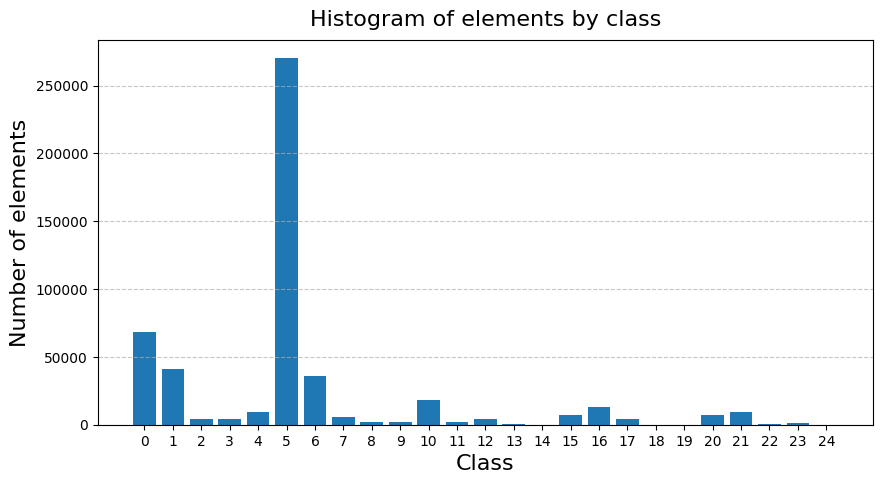

In [12]:
Number_1000 = [numero / 1e3 for numero in Number]

# Plotar o histograma
plt.figure(figsize=(10, 5))
plt.bar(np.arange(0,25), Number)
plt.xlabel("Class", fontsize= 16)
plt.ylabel("Number of elements", fontsize= 16)
plt.title("Histogram of elements by class", fontsize= 16, pad= 10)
plt.xticks(np.arange(0,25))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.yticks(np.arange(0, np.max(Number) + 5000, 50000))

#plt.savefig('SOM Segmentation Histogram 25 Classes.png', dpi=300, transparent=True, bbox_inches='tight')  # Salva com alta resolução

plt.show()

# K-means
- Reducing the number of classes using the K-MEANS algorithm.
    - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [13]:
pesos_neuronios = som.get_weights().reshape(tamanho_mapa[0]*tamanho_mapa[1], -1)

In [14]:
from sklearn.cluster import KMeans

# Set number of clusters you want
n_clusters = 3

# Apply k-means to the neuron weights
kmeans = KMeans(n_clusters=n_clusters, random_state=24)

labels_neuronios = kmeans.fit_predict(pesos_neuronios)

# Find BMU (winning neuron) for each data
bmus = np.array([som.winner(x) for x in data_reshaped])  # (512*872, 2)

# Convert position (x, y) to linear index
idx_bmus = bmus[:,0] * tamanho_mapa[1] + bmus[:,1]

# Assign k-means cluster label to data according to BMU
labels_dados = labels_neuronios[idx_bmus]

## PLOT - Histogram of elements by class (with K-Means)

In [15]:
import collections
contagem = collections.Counter(labels_dados)

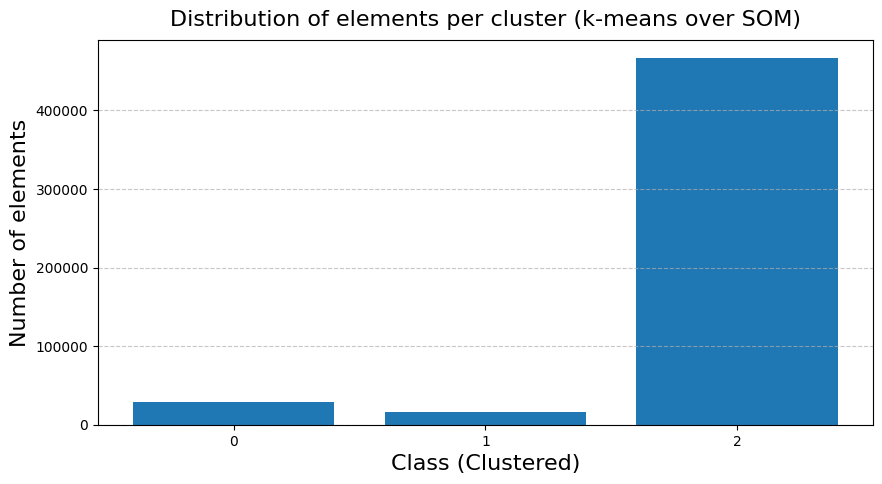

In [16]:
plt.figure(figsize=(10, 5))
plt.bar(np.arange(0, n_clusters), np.bincount(labels_dados))

plt.xlabel("Class (Clustered)", fontsize= 16)
plt.ylabel("Number of elements", fontsize= 16)
plt.title("Distribution of elements per cluster (k-means over SOM)", fontsize= 16, pad= 10)
plt.xticks(np.arange(0, n_clusters))
plt.grid(axis='y', linestyle='--', alpha=0.7)

#plt.savefig('Results_3/Hist_Class_with_PCA_.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

## Segmented figure (with K-Means)

Text(0.5, 1.0, 'K-means segmentation')

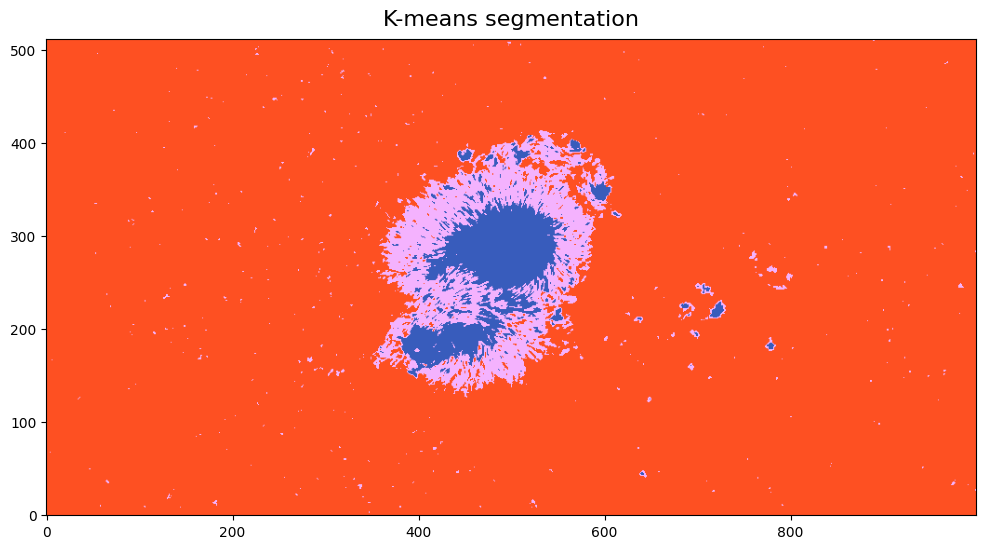

In [17]:
# Generate random colors for clusters
np.random.seed(24)
cores_clusters = np.random.rand(n_clusters, 3)  
cluster_cmap = ListedColormap(cores_clusters)

# Resize the labels vector to the image shape
labels_imagem = labels_dados.reshape(np.shape(imagem_segmentada)[0], np.shape(imagem_segmentada)[1])

# Create segmented RGB image
imagem_segmentada_clusters = cores_clusters[labels_imagem]

fig, ax = plt.subplots(figsize=(12, 8))

img = ax.imshow(imagem_segmentada_clusters, origin='lower', cmap=cluster_cmap)

plt.title('K-means segmentation', fontsize= 16, pad= 10)

#plt.savefig('K-means segmentation_SOM_3_Classes.png', dpi=300, transparent=True, bbox_inches='tight')  # Salva com alta resolução

# Select a class

In [18]:
desired_class = 1

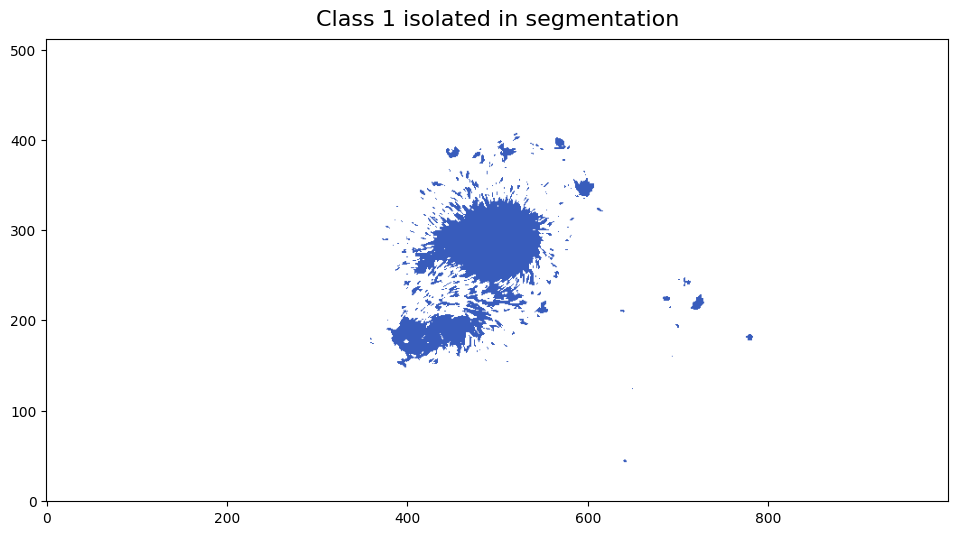

In [19]:
# Reshape labels for 2D image
labels_imagem = labels_dados.reshape(np.shape(imagem_segmentada)[0], np.shape(imagem_segmentada)[1])

# Boolean mask for the class
mascara = (labels_imagem == desired_class)
imagem_classe = np.ones_like(imagem_segmentada_clusters)

# Copy the colors of only the class pixels, the rest are black (0,0,0)
imagem_classe[mascara] = imagem_segmentada_clusters[mascara]

# Plot
plt.figure(figsize=(12,6))

plt.imshow(imagem_classe, origin='lower')
plt.title(f'Class {desired_class} isolated in segmentation', fontsize= 16, pad= 10)

#plt.axis('off')
#plt.savefig('SOM_K_MEANS_CLASS_'+ str(desired_class) +'.png', dpi=300, transparent=True, bbox_inches='tight') 

plt.show()

# Separate all classes

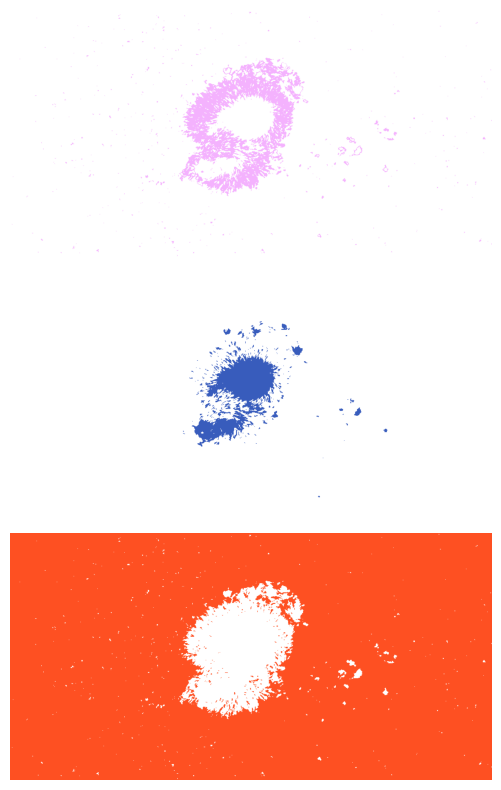

In [20]:
labels_imagem = labels_dados.reshape(imagem_segmentada_clusters.shape[0], imagem_segmentada_clusters.shape[1])
nrows = n_clusters 
ncols = 1

fig, axes = plt.subplots(nrows*ncols,1,  figsize=(10, 8))

axes = axes.ravel()

for i, classe_id in enumerate(np.unique(labels_dados)):

    mascara = (labels_imagem == classe_id)

    imagem_classe = np.ones_like(imagem_segmentada_clusters)

    imagem_classe[mascara] = imagem_segmentada_clusters[mascara]

    axes[i].imshow(imagem_classe, origin='lower')
    axes[i].axis('off')

plt.tight_layout()

#plt.savefig('Cut with all classes.png', dpi=300, transparent=True, bbox_inches='tight')  
plt.show()